<a href="https://colab.research.google.com/github/fyemane/TensorFlow-ZTM-/blob/main/10_time_series_forecasting_with_tensorflow_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

**Note:** This is not financial advice.

Links:
* All resources: https://github.com/mrdbourke/tensorflow-deep-learning
* Book version of actual code/text: https://dev.mrdbourke.com/tensorflow-deep-learning/

## Downloading and inspecting our Bitcoin historical dataset

### Get data

We're going to be using the historical price data of Bitcion to try and predict the future price of Bitcoin, we download the data from: https://www.coindesk.com/price/bitcoin/

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-07-23 14:42:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2023-07-23 14:42:23 (7.64 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series with pandas

In [ ]:
# Import with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 # https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
                 index_col=["Date"]) # Parse the data column and tell pandas column 1 is a datetimep
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [ ]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.

Typically deep learning models usually like lots of samples (where lots can be 1000s to 10000s to millions).

A smaller number of samples is something you'll often run into with time series data problems.

> **Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

### Visualizing our Bitcoin historical data with pandas

In [ ]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


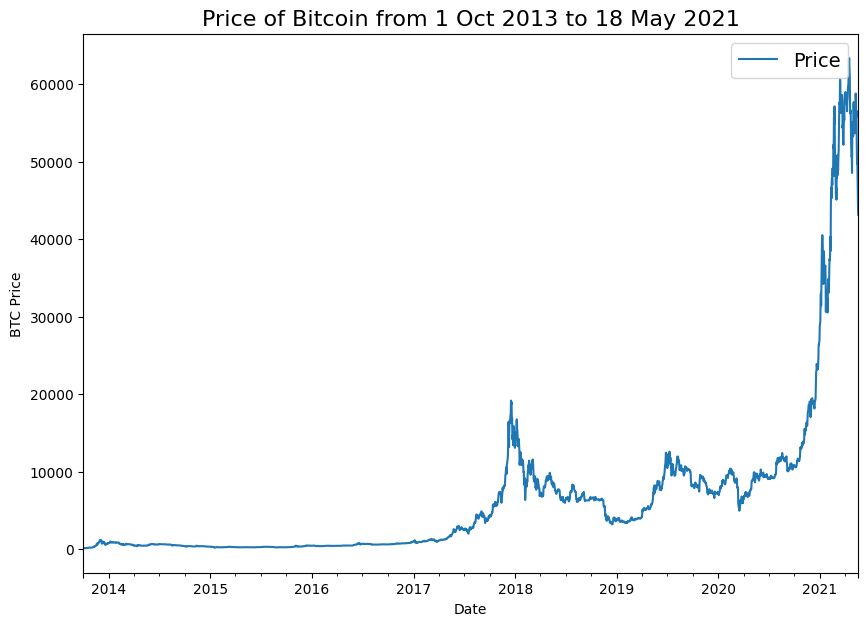

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

### Reading in our Bitcoin data with Python's CSV module

In [ ]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  # creates an iterator
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as date (not strings)
    btc_price.append(float(line[2])) # get closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

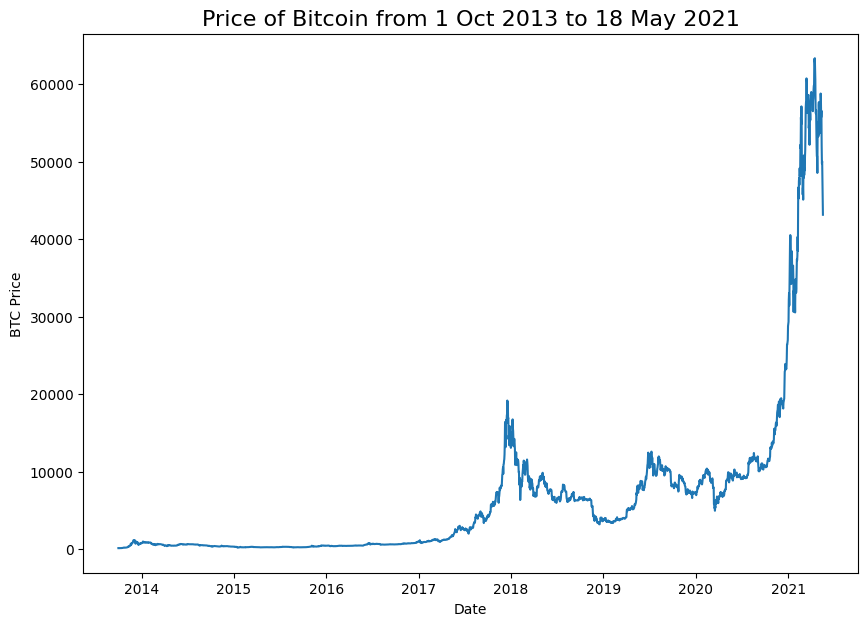

In [ ]:
# Plot from csv
import matplotlib.pyplot as plt
# import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date");

### Format data Part 1: Creating train and test splits for time series

In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()
timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # BTC prices
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

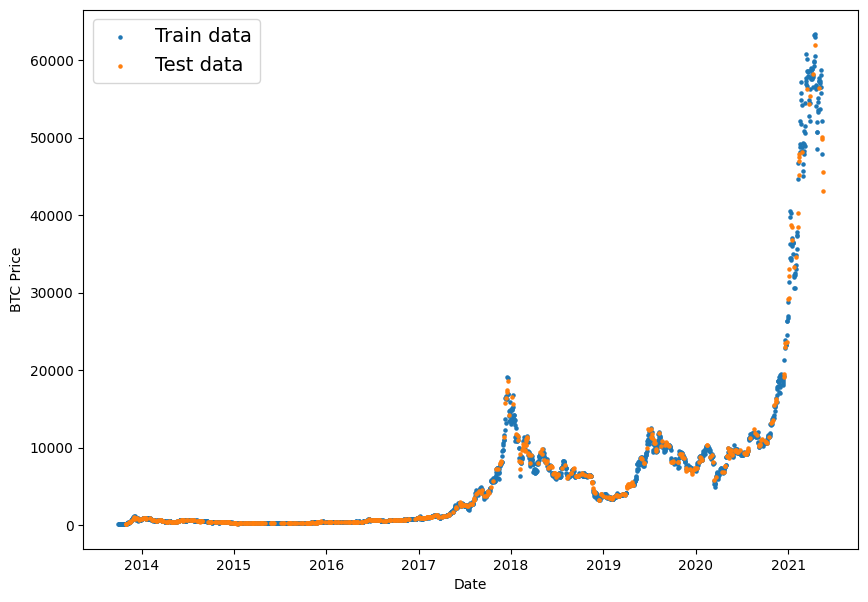

In [ ]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

In [ ]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test - you can change these values as needed, e.g. 90/10, 95/5

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

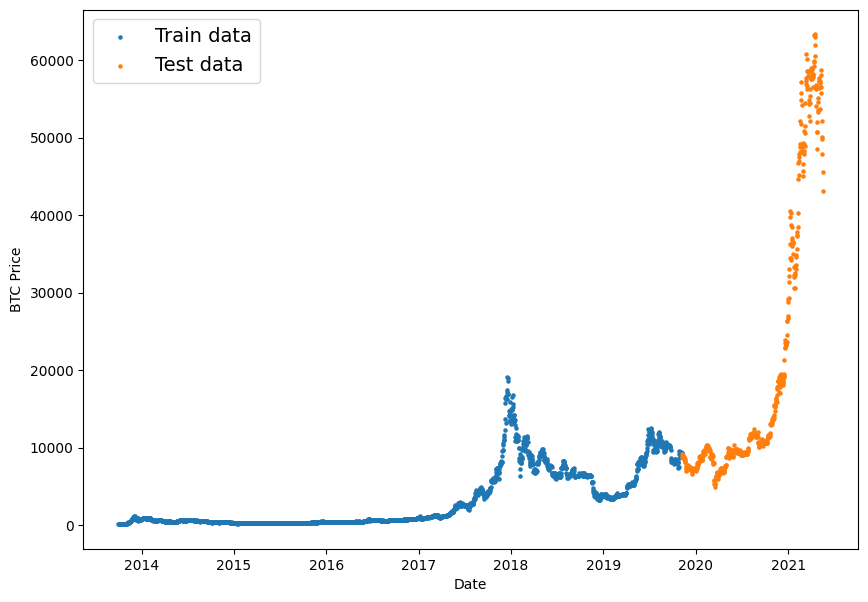

In [ ]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Creating a plotting function to visualize our time series data

Typing plotting code is tedious, let's functionalize it.

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps)

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None
  """
  # Plot series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

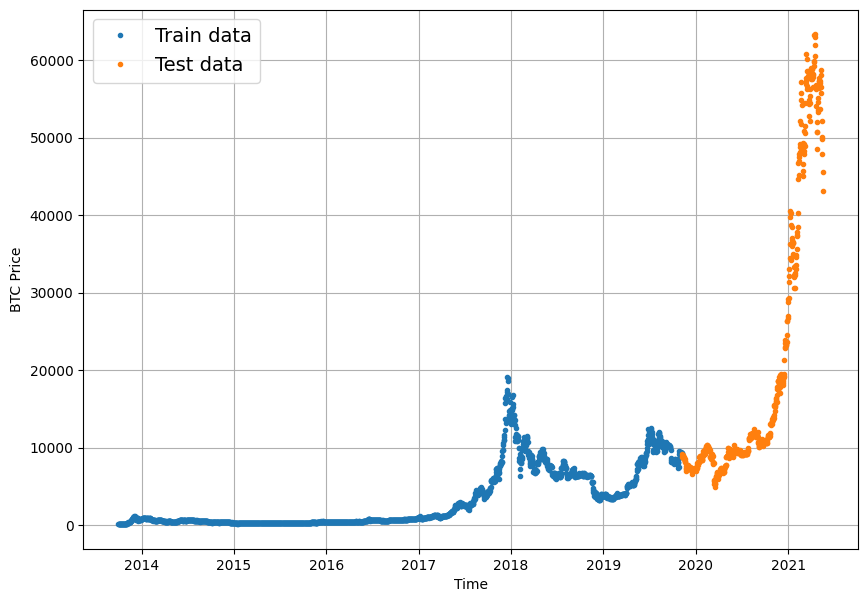

In [ ]:
# Test out plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Discussing the various modelling experiments we're going to be running

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict horizon

Modelling experiments we're running
Model Number	Model Type	Horizon size	Window size	Extra data
* 0	Naïve model (baseline)
* 1	Dense model, horizon = 1, window = 7
* 2	Same as 1, horizon = 1, window = 30
* 3	Same as 1, horizon = 7 , window = 30
* 4	Conv1D
* 5	LSTM
* 6	Same as 1 (but with multivariate data)
* 7	N-BEATs Algorithm
* 8	Ensemble (multiple models optimized on different loss functions)
* 9	Future prediction model (model to predict future values)
* 10	Same as 1 (but with turkey 🦃 data introduced)

## Model 0: Making and visualizing a naive forecast model

The formula looks like this:
$$\hat{y}_{t} = y_{t-1}$$

In English:
> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

https://otexts.com/fpp3/simple-methods.html

In [ ]:
y_test[:10]

array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
       8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
       8500.64355816, 8469.2608989 ])

In [ ]:
# Create a naive forecast which drops last position
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [ ]:
y_test[-10:]

array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
       52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
       45604.61575361, 43144.47129086])

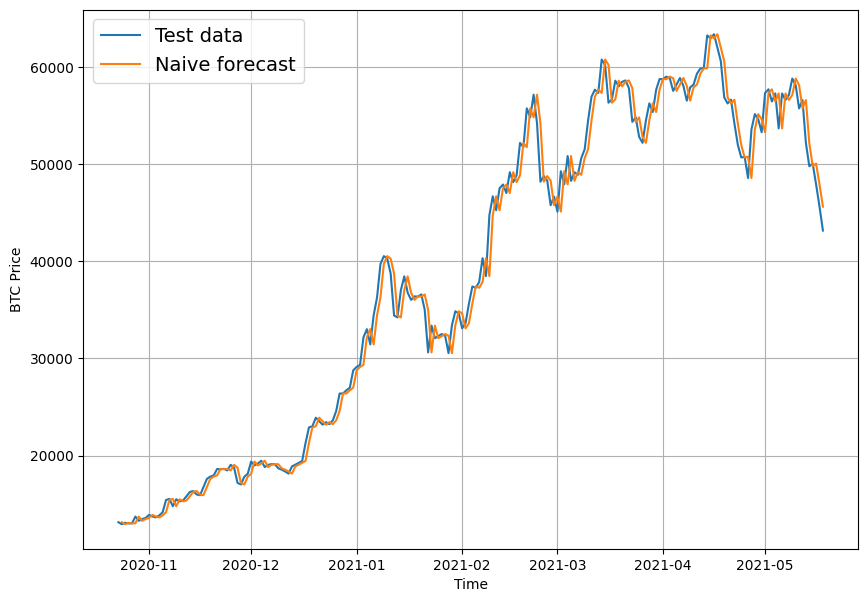

In [ ]:
# Plot naive foreecast
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive forecast")

> **Exercise:** Spend 10 minutes reading the simple forecasts chapter of [Forecasting: Principles in Practice](https://otexts.com/fpp3/simple-methods.html). And have a search to find out why the navie forecast is hard to beat. Does the term "autoregressive" come up?

### Discussing some of the most common time series evaluation metrics

Let's look into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a number, so that means we have a form of a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean squared error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, **lower** is better, for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: **how do our models forecasts (y_pred) compare against the actual values (y_true or ground truth values)?**

> **Resource:** For a deeper dive of the various kinds of time series forecasting methods see [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html)

### Implementing MASE with TensorFlow

In [ ]:
import tensorflow as tf

In [ ]:
 # MASE implementation
 # https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.performance_metrics.forecasting.mean_absolute_scaled_error.html
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)
  return mae / mae_naive_no_season

In [ ]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

### Creating a function to evaluate our model's forecasts with various metrics

In [ ]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (For metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

That's one good looking evaluation function!

Let's see if it works...

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)

naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [ ]:
naive_forecast[-10:] # last 10

array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
       56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361])

In [ ]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737222>

In [ ]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

### Discussing other non-TensorFlow kinds of time series forecasting models

In this notebook, we're focused on TensorFlow and deep learning models.

However, there are plenty of other styles of time series forecasting models you may want to experiment with:
https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts

### Formatting data Part 2: Creating a function to label our windowed time series

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [ ]:
len(y_train)

2229

In [ ]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict 123.033


In [ ]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

In [ ]:
btc_price[:10]

[123.65499,
 125.455,
 108.58483,
 118.67466,
 121.33866,
 120.65533,
 121.795,
 123.033,
 124.049,
 125.96116]

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


In [ ]:
tf.expand_dims(tf.range(8), axis=0)

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

### Writing a preprocessing function to turn time series data into windows & labels

We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage NumPy's array indexing - https://numpy.org/doc/1.21/reference/arrays.indexing.html.

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.

> **Resource:** The function we're about to create has been adapted from the following article: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5


In [ ]:
import numpy as np

# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size w
  with horizons size labels.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D arary of windows of size window_size
  # print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  # print(f"Windowed array:\n {windowed_array}")

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [ ]:
np.expand_dims(np.arange(7), axis=0)

array([[0, 1, 2, 3, 4, 5, 6]])

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [ ]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


> **Note:** There's a function which does similar to the above in `tf.keras.preprocessing`, an extension could be to try and replicate what we've done using the premade function: https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

### Turning our windowed time series data into training and test sets

In [ ]:
full_windows[:5], full_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [ ]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [ ]:
y_train

array([ 123.65499   ,  125.455     ,  108.58483   , ..., 9369.62808116,
       9326.59962378, 9335.75240233])

In [ ]:
# Check to see if train labels are the same (after and before window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

### Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example, if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following:
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [ ]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)

## Model 1: Building, compiling and fitting a deep learning model on Bitcoin data

### Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single Dense layer with 128 hidden units and ReLU activation
* An output layer with linear activation (no activation)
* Adam optimization and MAE loss function
* Batch size of 128 (previously we've used 32)

Why these values?

I picked them out of experimentation.

* **Hyperparameters** = values a machine learning practicioner (you!) can adjust themselves
* **Parameters** = values a model learns on its own

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear") # linear activation is same as having no activation
], name="model_1_dense") # name our model so we can save it

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
10/18 [===============>..............] - ETA: 0s - loss: 3486.8508 - mae: 3486.8508 - mse: 30269648.0000  

18/18 [==============================] - 9s 101ms/step - loss: 2752.8572 - mae: 2752.8572 - mse: 20812280.0000 - val_loss: 4856.8145 - val_mae: 4856.8145 - val_mse: 43699224.0000
Epoch 2/100
13/18 [====================>.........] - ETA: 0s - loss: 440.5235 - mae: 440.5235 - mse: 661925.3750 

18/18 [==============================] - 1s 68ms/step - loss: 405.1484 - mae: 405.1484 - mse: 580926.1875 - val_loss: 1121.2615 - val_mae: 1121.2615 - val_mse: 3781435.7500
Epoch 3/100
13/18 [====================>.........] - ETA: 0s - loss: 233.6655 - mae: 233.6655 - mse: 250910.6094

18/18 [==============================] - 1s 53ms/step - loss: 228.3007 - mae: 228.3007 - mse: 241379.6094 - val_loss: 1026.9604 - val_mae: 1026.9604 - val_mse: 3553537.7500
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 247.8455 - mae: 247.8455 - mse: 326065.3125

18/18 [==============================] - 1s 32ms/step - loss: 189.6317 - mae: 189.6317 - mse: 182858.1094 - val_loss: 1010.6580 - val_mae: 1010.6580 - val_mse: 3445926.7500
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 181.8985 - mae: 181.8985 - mse: 174683.9844 - val_loss: 1017.8102 - val_mae: 1017.8102 - val_mse: 3303516.0000
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 136.5425 - mae: 136.5425 - mse: 69716.7656

18/18 [==============================] - 1s 30ms/step - loss: 174.9109 - mae: 174.9109 - mse: 163376.1875 - val_loss: 971.1469 - val_mae: 971.1468 - val_mse: 3186086.5000
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 219.0661 - mae: 219.0661 - mse: 335157.0938

18/18 [==============================] - 1s 31ms/step - loss: 171.2465 - mae: 171.2465 - mse: 157600.8750 - val_loss: 954.8697 - val_mae: 954.8697 - val_mse: 3007504.5000
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 147.8221 - mae: 147.8221 - mse: 89375.3750

18/18 [==============================] - 1s 43ms/step - loss: 166.9709 - mae: 166.9709 - mse: 151102.5312 - val_loss: 929.3860 - val_mae: 929.3860 - val_mse: 2881055.2500
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 164.8716 - mae: 164.8716 - mse: 147314.4062 - val_loss: 954.8026 - val_mae: 954.8026 - val_mse: 2849952.2500
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 180.2336 - mae: 180.2336 - mse: 214330.3750

18/18 [==============================] - 1s 30ms/step - loss: 160.7827 - mae: 160.7827 - mse: 140681.5000 - val_loss: 881.7873 - val_mae: 881.7873 - val_mse: 2623959.5000
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 174.3325 - mae: 174.3325 - mse: 132720.0000

18/18 [==============================] - 1s 32ms/step - loss: 154.8301 - mae: 154.8301 - mse: 131214.0781 - val_loss: 840.5430 - val_mae: 840.5430 - val_mse: 2370680.7500
Epoch 12/100
18/18 [==============================] - ETA: 0s - loss: 148.0378 - mae: 148.0378 - mse: 121120.8359

18/18 [==============================] - 1s 45ms/step - loss: 148.0378 - mae: 148.0378 - mse: 121120.8359 - val_loss: 838.3890 - val_mae: 838.3890 - val_mse: 2270387.0000
Epoch 13/100
18/18 [==============================] - 0s 8ms/step - loss: 146.1749 - mae: 146.1749 - mse: 118797.7891 - val_loss: 873.0895 - val_mae: 873.0895 - val_mse: 2296808.7500
Epoch 14/100
14/18 [======================>.......] - ETA: 0s - loss: 143.1704 - mae: 143.1704 - mse: 112817.5234

18/18 [==============================] - 1s 44ms/step - loss: 143.1684 - mae: 143.1684 - mse: 111634.4375 - val_loss: 833.6829 - val_mae: 833.6829 - val_mse: 2146816.2500
Epoch 15/100
13/18 [====================>.........] - ETA: 0s - loss: 138.5899 - mae: 138.5899 - mse: 105963.6719

18/18 [==============================] - 1s 41ms/step - loss: 140.2900 - mae: 140.2900 - mse: 109682.9062 - val_loss: 758.1483 - val_mae: 758.1483 - val_mse: 1933604.1250
Epoch 16/100
18/18 [==============================] - 0s 5ms/step - loss: 135.2003 - mae: 135.2003 - mse: 102319.2578 - val_loss: 761.9116 - val_mae: 761.9116 - val_mse: 1890137.0000
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 132.4866 - mae: 132.4866 - mse: 98987.3906 - val_loss: 776.3285 - val_mae: 776.3285 - val_mse: 1888510.5000
Epoch 18/100
18/18 [==============================] - 0s 6ms/step - loss: 133.1243 - mae: 133.1243 - mse: 99615.0781 - val_loss: 770.1230 - val_mae: 770.1230 - val_mse: 1844428.8750
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 83.4053 - mae: 83.4053 - mse: 38988.2812

18/18 [==============================] - 1s 30ms/step - loss: 128.3791 - mae: 128.3791 - mse: 92523.7734 - val_loss: 747.9845 - val_mae: 747.9845 - val_mse: 1765299.1250
Epoch 20/100
18/18 [==============================] - ETA: 0s - loss: 126.0809 - mae: 126.0809 - mse: 91309.7734 

18/18 [==============================] - 1s 30ms/step - loss: 126.0809 - mae: 126.0809 - mse: 91309.7734 - val_loss: 694.7761 - val_mae: 694.7761 - val_mse: 1663387.1250
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 165.9159 - mae: 165.9159 - mse: 122674.2031

18/18 [==============================] - 1s 30ms/step - loss: 128.3926 - mae: 128.3926 - mse: 94397.5469 - val_loss: 678.8517 - val_mae: 678.8517 - val_mse: 1557368.1250
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 179.9201 - mae: 179.9201 - mse: 181690.4062

18/18 [==============================] - 1s 32ms/step - loss: 123.7442 - mae: 123.7442 - mse: 88121.6484 - val_loss: 672.2704 - val_mae: 672.2704 - val_mse: 1523488.0000
Epoch 23/100
18/18 [==============================] - 0s 5ms/step - loss: 125.6344 - mae: 125.6344 - mse: 88789.3516 - val_loss: 674.1390 - val_mae: 674.1390 - val_mse: 1513995.8750
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 130.6195 - mae: 130.6195 - mse: 76664.5938

18/18 [==============================] - 1s 31ms/step - loss: 122.7699 - mae: 122.7699 - mse: 85372.7500 - val_loss: 650.7894 - val_mae: 650.7894 - val_mse: 1471225.6250
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 126.9049 - mae: 126.9049 - mse: 65829.8750

18/18 [==============================] - 1s 30ms/step - loss: 119.2056 - mae: 119.2056 - mse: 82333.5312 - val_loss: 643.0840 - val_mae: 643.0840 - val_mse: 1426494.7500
Epoch 26/100
13/18 [====================>.........] - ETA: 0s - loss: 115.5574 - mae: 115.5574 - mse: 70370.2969

18/18 [==============================] - 1s 32ms/step - loss: 118.9747 - mae: 118.9747 - mse: 81396.0000 - val_loss: 636.4129 - val_mae: 636.4129 - val_mse: 1403669.0000
Epoch 27/100
18/18 [==============================] - ETA: 0s - loss: 119.8202 - mae: 119.8202 - mse: 81552.6641 

18/18 [==============================] - 1s 33ms/step - loss: 119.8202 - mae: 119.8202 - mse: 81552.6641 - val_loss: 630.7496 - val_mae: 630.7496 - val_mse: 1394254.2500
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 109.7733 - mae: 109.7733 - mse: 69438.9453

18/18 [==============================] - 1s 32ms/step - loss: 116.4005 - mae: 116.4005 - mse: 79834.7422 - val_loss: 628.9398 - val_mae: 628.9398 - val_mse: 1368546.3750
Epoch 29/100
18/18 [==============================] - 0s 6ms/step - loss: 116.4040 - mae: 116.4040 - mse: 79051.3516 - val_loss: 639.9089 - val_mae: 639.9089 - val_mse: 1384644.6250
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 131.6064 - mae: 131.6064 - mse: 88644.7344

18/18 [==============================] - 1s 32ms/step - loss: 121.2598 - mae: 121.2598 - mse: 82022.5781 - val_loss: 615.0651 - val_mae: 615.0651 - val_mse: 1335834.8750
Epoch 31/100
18/18 [==============================] - 0s 6ms/step - loss: 114.2231 - mae: 114.2231 - mse: 75943.5156 - val_loss: 620.1748 - val_mae: 620.1748 - val_mse: 1330328.6250
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 111.0722 - mae: 111.0722 - mse: 78510.5938

18/18 [==============================] - 1s 31ms/step - loss: 114.6215 - mae: 114.6215 - mse: 78700.4688 - val_loss: 606.0750 - val_mae: 606.0750 - val_mse: 1304622.6250
Epoch 33/100
18/18 [==============================] - 0s 6ms/step - loss: 115.1867 - mae: 115.1867 - mse: 77752.3672 - val_loss: 632.9799 - val_mae: 632.9799 - val_mse: 1350257.7500
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 114.3880 - mae: 114.3880 - mse: 77759.4688 - val_loss: 612.8525 - val_mae: 612.8525 - val_mse: 1324065.1250
Epoch 35/100
16/18 [=========================>....] - ETA: 0s - loss: 111.7448 - mae: 111.7448 - mse: 77674.6953

18/18 [==============================] - 1s 48ms/step - loss: 111.7799 - mae: 111.7799 - mse: 75770.3203 - val_loss: 599.0978 - val_mae: 599.0978 - val_mse: 1282900.0000
Epoch 36/100
 1/18 [>.............................] - ETA: 0s - loss: 160.7780 - mae: 160.7780 - mse: 152062.5938

18/18 [==============================] - 1s 32ms/step - loss: 115.9181 - mae: 115.9181 - mse: 76928.5000 - val_loss: 594.6506 - val_mae: 594.6506 - val_mse: 1263611.1250
Epoch 37/100
18/18 [==============================] - 0s 5ms/step - loss: 113.5810 - mae: 113.5810 - mse: 76765.9297 - val_loss: 607.4686 - val_mae: 607.4686 - val_mse: 1280285.5000
Epoch 38/100
18/18 [==============================] - 0s 6ms/step - loss: 114.7492 - mae: 114.7492 - mse: 75465.6875 - val_loss: 611.1714 - val_mae: 611.1714 - val_mse: 1302954.0000
Epoch 39/100
18/18 [==============================] - 0s 6ms/step - loss: 115.9443 - mae: 115.9443 - mse: 75552.2188 - val_loss: 598.2122 - val_mae: 598.2122 - val_mse: 1256708.7500
Epoch 40/100
18/18 [==============================] - 0s 5ms/step - loss: 113.2529 - mae: 113.2529 - mse: 73500.7578 - val_loss: 612.8403 - val_mae: 612.8403 - val_mse: 1300499.5000
Epoch 41/100
18/18 [==============================] - 0s 6ms/step - loss: 110.9220 - mae: 110.9220 - m

18/18 [==============================] - 1s 30ms/step - loss: 115.0568 - mae: 115.0568 - mse: 74947.1719 - val_loss: 585.8346 - val_mae: 585.8346 - val_mse: 1224978.3750
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 109.8064 - mae: 109.8064 - mse: 73739.5781 - val_loss: 598.2825 - val_mae: 598.2825 - val_mse: 1256988.3750
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 110.3527 - mae: 110.3527 - mse: 72099.4766 - val_loss: 586.4359 - val_mae: 586.4359 - val_mse: 1222970.8750
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 110.7231 - mae: 110.7231 - mse: 73927.9141 - val_loss: 611.3412 - val_mae: 611.3412 - val_mse: 1270305.0000
Epoch 48/100
18/18 [==============================] - 0s 6ms/step - loss: 109.4975 - mae: 109.4975 - mse: 73091.5859 - val_loss: 606.5822 - val_mae: 606.5822 - val_mse: 1258577.2500
Epoch 49/100
12/18 [===================>..........] - ETA: 0s - loss: 120.8434 - mae: 120.8434 - mse: 

18/18 [==============================] - 1s 46ms/step - loss: 114.2586 - mae: 114.2586 - mse: 74485.5859 - val_loss: 574.7524 - val_mae: 574.7524 - val_mse: 1203115.1250
Epoch 50/100
18/18 [==============================] - 0s 10ms/step - loss: 111.8021 - mae: 111.8021 - mse: 73305.4766 - val_loss: 669.8560 - val_mae: 669.8560 - val_mse: 1428256.0000
Epoch 51/100
18/18 [==============================] - 0s 8ms/step - loss: 113.2424 - mae: 113.2424 - mse: 74251.4922 - val_loss: 595.6357 - val_mae: 595.6357 - val_mse: 1231969.8750
Epoch 52/100
18/18 [==============================] - 0s 8ms/step - loss: 114.0769 - mae: 114.0769 - mse: 76101.0625 - val_loss: 595.6274 - val_mae: 595.6274 - val_mse: 1238540.6250
Epoch 53/100
18/18 [==============================] - 0s 7ms/step - loss: 111.7418 - mae: 111.7418 - mse: 73615.8047 - val_loss: 624.4409 - val_mae: 624.4409 - val_mse: 1296218.8750
Epoch 54/100
18/18 [==============================] - 0s 7ms/step - loss: 111.1786 - mae: 111.1786 - 

18/18 [==============================] - 1s 31ms/step - loss: 109.3899 - mae: 109.3899 - mse: 71445.9219 - val_loss: 569.6179 - val_mae: 569.6179 - val_mse: 1177590.6250
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 118.9659 - mae: 118.9659 - mse: 86129.4453

18/18 [==============================] - 1s 32ms/step - loss: 106.7736 - mae: 106.7736 - mse: 70086.3594 - val_loss: 569.2881 - val_mae: 569.2881 - val_mse: 1173163.5000
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 106.7440 - mae: 106.7440 - mse: 69648.1328 - val_loss: 659.7225 - val_mae: 659.7225 - val_mse: 1381991.5000
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 116.5121 - mae: 116.5121 - mse: 71193.9219 - val_loss: 728.2083 - val_mae: 728.2083 - val_mse: 1580249.5000
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 127.7866 - mae: 127.7866 - mse: 83552.4844 - val_loss: 689.9313 - val_mae: 689.9313 - val_mse: 1465727.2500
Epoch 70/100
18/18 [==============================] - 0s 5ms/step - loss: 121.3929 - mae: 121.3929 - mse: 79365.0859 - val_loss: 569.8771 - val_mae: 569.8771 - val_mse: 1171968.8750
Epoch 71/100
18/18 [==============================] - 0s 5ms/step - loss: 111.9667 - mae: 111.9667 - m

18/18 [==============================] - 1s 31ms/step - loss: 108.0138 - mae: 108.0138 - mse: 70777.6797 - val_loss: 567.1127 - val_mae: 567.1127 - val_mse: 1169526.1250
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 110.5869 - mae: 110.5869 - mse: 71804.6797 - val_loss: 590.5567 - val_mae: 590.5567 - val_mse: 1215542.5000
Epoch 74/100
18/18 [==============================] - 0s 6ms/step - loss: 107.0455 - mae: 107.0455 - mse: 70520.6797 - val_loss: 569.3871 - val_mae: 569.3871 - val_mse: 1171856.3750
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 107.4249 - mae: 107.4249 - mse: 70554.4062 - val_loss: 593.0559 - val_mae: 593.0559 - val_mse: 1214513.5000
Epoch 76/100
18/18 [==============================] - 0s 6ms/step - loss: 108.1321 - mae: 108.1321 - mse: 70763.6328 - val_loss: 567.9667 - val_mae: 567.9667 - val_mse: 1164734.8750
Epoch 77/100
 1/18 [>.............................] - ETA: 0s - loss: 83.8177 - mae: 83.8177 - mse: 60

18/18 [==============================] - 1s 31ms/step - loss: 106.1077 - mae: 106.1077 - mse: 68885.4688 - val_loss: 565.6012 - val_mae: 565.6012 - val_mse: 1163491.0000
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 107.3003 - mae: 107.3003 - mse: 68952.9219 - val_loss: 575.4180 - val_mae: 575.4180 - val_mse: 1180824.5000
Epoch 79/100
18/18 [==============================] - 0s 6ms/step - loss: 107.0554 - mae: 107.0554 - mse: 70165.4141 - val_loss: 576.6188 - val_mae: 576.6188 - val_mse: 1182892.6250
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 106.8443 - mae: 106.8443 - mse: 70569.5547 - val_loss: 588.9159 - val_mae: 588.9159 - val_mse: 1202908.1250
Epoch 81/100
18/18 [==============================] - 0s 5ms/step - loss: 107.2742 - mae: 107.2742 - mse: 70311.4609 - val_loss: 577.8160 - val_mae: 577.8160 - val_mse: 1184936.7500
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 113.9970 - mae: 113.9970 - m

18/18 [==============================] - 1s 32ms/step - loss: 106.8362 - mae: 106.8362 - mse: 69013.6016 - val_loss: 563.8581 - val_mae: 563.8581 - val_mse: 1154092.8750
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 106.0832 - mae: 106.0832 - mse: 69071.5312 - val_loss: 606.1165 - val_mae: 606.1165 - val_mse: 1244278.7500
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 107.9320 - mae: 107.9320 - mse: 71520.7969 - val_loss: 565.7532 - val_mae: 565.7532 - val_mse: 1158293.3750
Epoch 89/100
18/18 [==============================] - 0s 5ms/step - loss: 106.4294 - mae: 106.4294 - mse: 69335.5781 - val_loss: 568.5219 - val_mae: 568.5219 - val_mse: 1162663.8750
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 105.6830 - mae: 105.6830 - mse: 68293.5391 - val_loss: 630.5875 - val_mae: 630.5875 - val_mse: 1293133.6250
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 112.4427 - mae: 112.4427 - m

18/18 [==============================] - 1s 32ms/step - loss: 106.7168 - mae: 106.7168 - mse: 69839.1406 - val_loss: 563.1504 - val_mae: 563.1504 - val_mse: 1150193.3750
Epoch 98/100
18/18 [==============================] - 0s 6ms/step - loss: 105.8417 - mae: 105.8417 - mse: 69453.7500 - val_loss: 563.8733 - val_mae: 563.8733 - val_mse: 1152378.5000
Epoch 99/100
 1/18 [>.............................] - ETA: 0s - loss: 149.5552 - mae: 149.5552 - mse: 123505.9297

18/18 [==============================] - 1s 31ms/step - loss: 107.6277 - mae: 107.6277 - mse: 70562.0781 - val_loss: 562.9423 - val_mae: 562.9423 - val_mse: 1148993.3750
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 118.8260 - mae: 118.8260 - mse: 73725.4922 - val_loss: 693.5665 - val_mae: 693.5665 - val_mse: 1450979.3750


In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [ ]:
# Evalaute model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 693.5667 - mae: 693.5667 - mse: 1450979.6250


[693.566650390625, 693.566650390625, 1450979.625]

In [ ]:
# Load in saved best performance model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("/content/model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 562.9420 - mae: 562.9420 - mse: 1148992.7500


[562.9420166015625, 562.9420166015625, 1148992.75]

### Creating a function to make predictions with our trained models

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future), let's write a function to:
1. Take in a trained model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions


In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [ ]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8851.811, 8795.846, 9062.708, 8783.851, 8753.826, 8764.113,
        8674.86 , 8548.975, 8467.146, 8546.226], dtype=float32)>)

In [ ]:
test_labels[:10]

array([[8798.04205463],
       [9081.18687849],
       [8711.53433917],
       [8760.89271814],
       [8749.52059102],
       [8656.97092235],
       [8500.64355816],
       [8469.2608989 ],
       [8537.33965197],
       [8205.80636599]])

In [ ]:
tf.squeeze(test_labels).shape, model_1_preds.shape

(TensorShape([556]), TensorShape([556]))

In [ ]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 562.942,
 'mse': 1148992.8,
 'rmse': 1071.9108,
 'mape': 2.5111601,
 'mase': 0.9889332}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

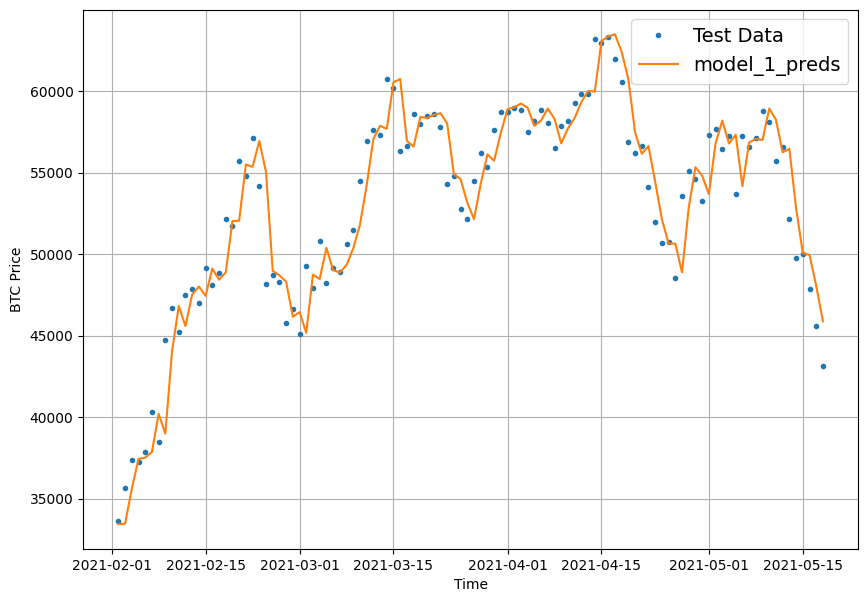

In [ ]:
# Let's plot our model_1 predictions
offset = 450
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:,0],
                 start=offset,
                 label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="model_1_preds")
# model lags from autocorrelation - https://otexts.com/fpp3/acf.html

## Model 2: Building, fitting and evaluating a deep model with a larger window size

### Model 2: Dense (window = 30, horizon = 1)

In [ ]:
HORIZON = 1 # predict one step at a time (one day of Bitcoin prices)
WINDOW_SIZE = 30 # use 30 timesteps in past

In [ ]:
# Make windowed data with appropriate horizons and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [ ]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [ ]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_2_dense")

# Compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [ ]:
# Evaluate model_2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 618.2645 - mae: 618.2645


[618.2644653320312, 618.2644653320312]

In [ ]:
# Load in the best performing modle
model_2 = tf.keras.models.load_model("/content/model_experiments/model_2_dense")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 608.1796 - mae: 608.1796


[608.1795654296875, 608.1795654296875]

In [ ]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 4ms/step


In [ ]:
tf.squeeze(test_labels).shape, model_2_preds.shape

(TensorShape([552]), TensorShape([552]))

In [ ]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 608.17957,
 'mse': 1304495.2,
 'rmse': 1142.145,
 'mape': 2.7378156,
 'mase': 1.0631039}

In [ ]:
model_1_results

{'mae': 562.942,
 'mse': 1148992.8,
 'rmse': 1071.9108,
 'mape': 2.5111601,
 'mase': 0.9889332}

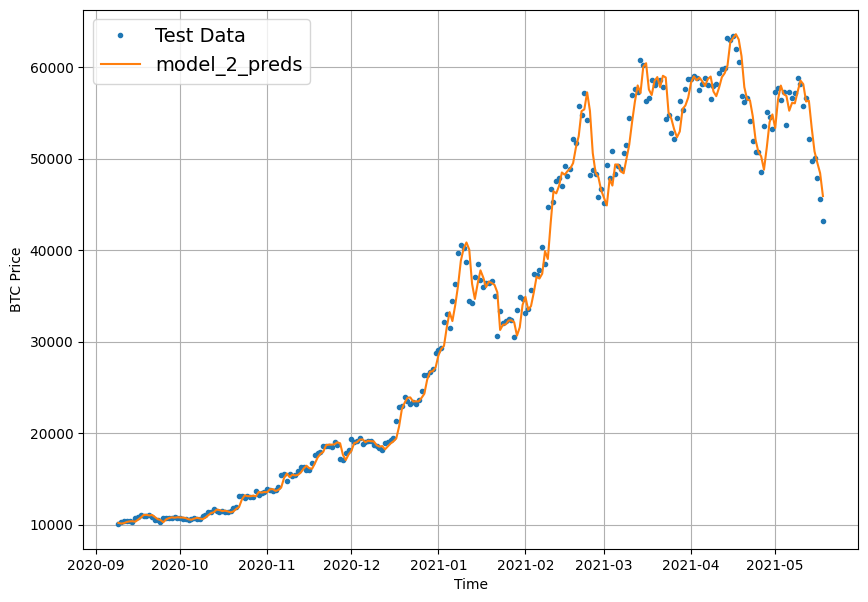

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_2_preds,
                 start=offset,
                 format="-",
                 label="model_2_preds")

## Model 3: Building, fitting and evaluating a model with a larger horizon size

### Model 3: Dense (window = 30, horizon = 7)

In [ ]:
prices[:10]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  , 123.033  , 124.049  , 125.96116])

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [ ]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input and output sizes)
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_3_dense")

# Compile
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [ ]:
# Evaluate the model on the test data
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1364.7611


1364.7611083984375

In [ ]:
# Load best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("/content/model_experiments/model_3_dense")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1237.8221


1237.8221435546875

In [ ]:
# Make predictions with model_3
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9324.138 , 9426.645 , 9534.122 , 9482.631 , 9406.717 , 9508.541 ,
        9366.523 ],
       [9192.517 , 8985.444 , 9257.991 , 9180.877 , 9043.865 , 9222.0625,
        9049.136 ],
       [8887.44  , 8720.78  , 8979.054 , 8901.117 , 8798.786 , 9039.945 ,
        8835.26  ],
       [9046.361 , 8949.069 , 9232.259 , 9069.046 , 9019.269 , 9168.492 ,
        9038.493 ],
       [8840.164 , 8902.409 , 9171.576 , 9126.225 , 9107.75  , 9198.141 ,
        9028.345 ]], dtype=float32)>

In [ ]:
model_2_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8745.166, 8792.636, 8748.866, 8483.61 , 8317.254], dtype=float32)>

In [ ]:
model_3_preds.shape, model_2_preds.shape, model_1_preds.shape

(TensorShape([551, 7]), TensorShape([552]), TensorShape([556]))

In [ ]:
model_1_results, model_2_results

({'mae': 562.942,
  'mse': 1148992.8,
  'rmse': 1071.9108,
  'mape': 2.5111601,
  'mase': 0.9889332},
 {'mae': 608.17957,
  'mse': 1304495.2,
  'rmse': 1142.145,
  'mape': 2.7378156,
  'mase': 1.0631039})

In [ ]:
# Evaluate model_3 results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  642.4017  ,   409.2267  ,   231.40945 ,   448.11816 ,
          499.16782 ,   583.8871  ,   541.57184 ,   538.44916 ,
          478.1736  ,   510.14273 ,   841.43744 ,   776.3218  ,
          817.4121  ,   836.52716 ,   667.52527 ,   285.2936  ,
          233.96631 ,   190.80678 ,   237.94106 ,   268.70535 ,
          177.85916 ,   219.59668 ,   359.1098  ,   368.16287 ,
          224.84828 ,   108.654366,   185.11629 ,   117.6596  ,
          113.47294 ,   262.2825  ,   359.1977  ,   371.10873 ,
          334.80707 ,   365.6347  ,   275.67584 ,   282.30664 ,
          370.22565 ,   256.52148 ,   183.75656 ,   196.52637 ,
          466.1061  ,    90.694756,    83.94511 ,    81.14425 ,
           48.72196 ,   171.47963 ,    46.89432 ,   132.95041 ,
           96.492325,    92.979774,   102.50795 ,   136.595   ,
          218.91623 ,   189.90758 ,   230.05469 ,   360.41998 ,
          569.8651  ,   551.8859  ,   434.2553  ,   507.1141  ,
          390.61188 ,   186.63414

###  Adjusting the evaluation function to work for predictions with larger horizons

In [ ]:
model_3_results["mae"].shape, model_2_results["mae"].shape

((551,), ())

In [ ]:
model_3_results["mae"].ndim, model_2_results["mae"].ndim

(1, 0)

In [ ]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (For metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
tf.reduce_mean(model_3_results["mae"]).numpy()

1237.822

In [ ]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1237.8221


1237.8221435546875

In [ ]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1237.822,
 'mse': 5418676.5,
 'rmse': 1426.379,
 'mape': 5.574528,
 'mase': 2.202635}

In [ ]:
model_1_results, model_2_results, naive_results

({'mae': 562.942,
  'mse': 1148992.8,
  'rmse': 1071.9108,
  'mape': 2.5111601,
  'mase': 0.9889332},
 {'mae': 608.17957,
  'mse': 1304495.2,
  'rmse': 1142.145,
  'mape': 2.7378156,
  'mase': 1.0631039},
 {'mae': 567.9802,
  'mse': 1147547.0,
  'rmse': 1071.2362,
  'mape': 2.516525,
  'mase': 0.99957})

### Model 3: Visualizing the results

We've made and evaluated predictions with `model_3`, let's visualize, visualize, visualize!


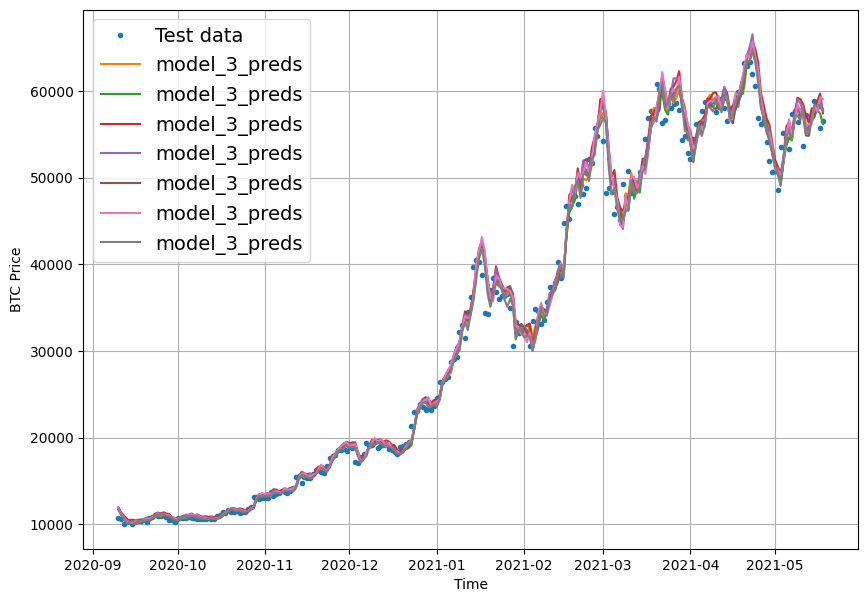

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_3_preds,
                 start=offset,
                 format="-",
                 label="model_3_preds")

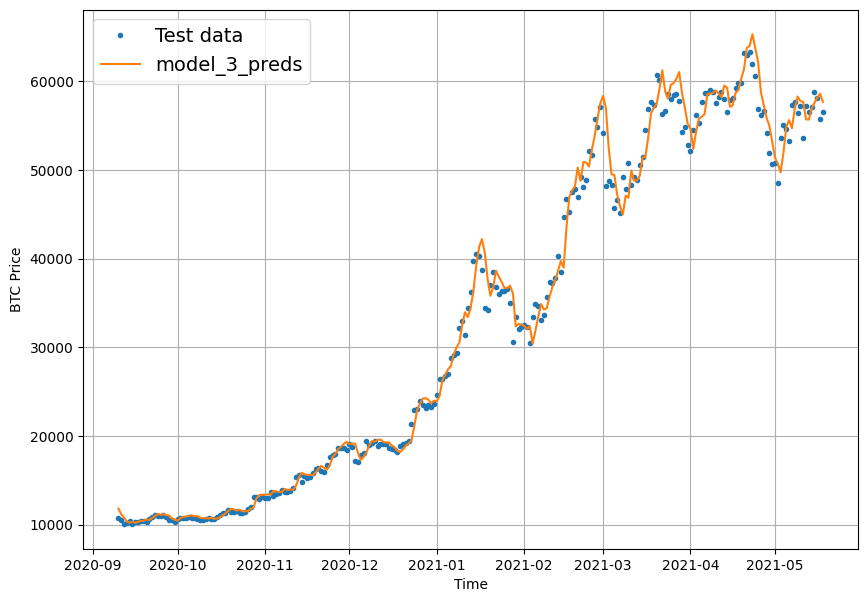

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 start=offset,
                 format="-",
                 label="model_3_preds")

In [ ]:
model_3_preds[0]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([9324.138, 9426.645, 9534.122, 9482.631, 9406.717, 9508.541,
       9366.523], dtype=float32)>

In [ ]:
tf.reduce_mean(model_3_preds[0])

<tf.Tensor: shape=(), dtype=float32, numpy=9435.616>

### Comparing our modelling experiments so far and discussing autocorrelation

So we've trained a few models, now let' compare them and see how they've gone...

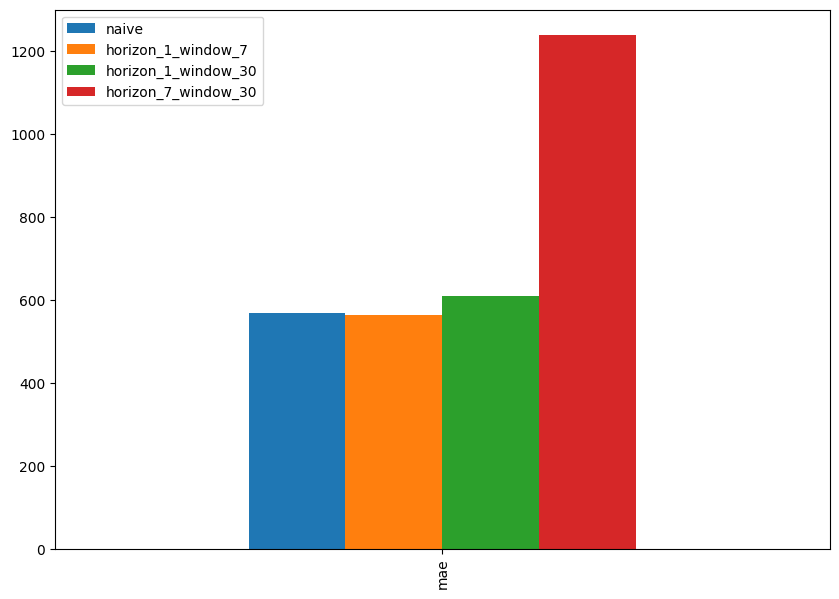

In [ ]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]},
             index=["mae"]).plot(figsize=(10, 7), kind="bar");

## Model 4: Conv1D  

### Preparing data for building a Conv1D model

In [ ]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth dat

In [ ]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# Create train and test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

To use the Conv1D layer, We need an input sahpe of: `[batch_size, timesteps, input_dim]`

However our data isn't in that shape yet...

In [ ]:
# Check data input shape
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [ ]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works.
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for `input dim`

In [ ]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # Output = ...?
# model views 1 sample of train_windows at a time to predict a horizon of 1
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


### Model 4: Building, fitting and evaluating a Conv1D model on our Bitcoin data

In [ ]:
tf.random.set_seed(42)

# Create Conv1D model
model_4 = tf.keras.Sequential([
    # lambda layer
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # adjust size of input data
    layers.Conv1D(filters=128, kernel_size=7, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [ ]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            6400      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.summary()

Model: "model_2_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               3968      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Evaluate model...
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 649.3787


649.3787231445312

In [ ]:
# Load back in best performing Conv1D model and re-evaluate
model_4 = tf.keras.models.load_model("/content/model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 573.5624


573.5624389648438

In [ ]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8887.145, 8778.215, 8984.286, 8782.82 , 8715.644, 8726.639,
       8663.68 , 8542.853, 8436.665, 8508.481], dtype=float32)>

In [ ]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 573.56244,
 'mse': 1199248.2,
 'rmse': 1095.1019,
 'mape': 2.576868,
 'mase': 1.0075903}

In [ ]:
model_1_results

{'mae': 562.942,
 'mse': 1148992.8,
 'rmse': 1071.9108,
 'mape': 2.5111601,
 'mase': 0.9889332}

## Model 5: Building, fitting and evaluating a LSTM (RNN) model on our Bitcoin data

### Model 5: RNN (LSTM)

Let's build an RNN model for our time series data.

We'll use the same data we created previously.


In [ ]:
train_windows[:5]

array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  ],
       [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
        123.033  ],
       [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
        124.049  ],
       [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
        125.96116],
       [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
        125.27966]])

In [ ]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_LSTM")

# Compile
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
18/18 [==============================] - 5s 118ms/step - loss: 2362.5452 - val_loss: 9532.3779
Epoch 2/100
18/18 [==============================] - 2s 104ms/step - loss: 668.7443 - val_loss: 1868.4047
Epoch 3/100
18/18 [==============================] - 2s 103ms/step - loss: 255.9238 - val_loss: 1449.1837
Epoch 4/100
18/18 [==============================] - 2s 122ms/step - loss: 202.3439 - val_loss: 1082.2828
Epoch 5/100
18/18 [==============================] - 2s 103ms/step - loss: 192.0486 - val_loss: 996.8690
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 191.8399 - val_loss: 1098.7131
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 197.5556 - val_loss: 1087.3667
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 189.3179 - val_loss: 1023.4080
Epoch 9/100
18/18 [==============================] - 0s 9ms/step - loss: 191.1362 - val_loss: 1062.6746
Epoch 10/100
18/18 [==============================] - 

In [ ]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("/content/model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 584.1848


584.184814453125

In [ ]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([8955.91  , 8837.7295, 8993.497 , 8807.692 , 8777.434 ],
      dtype=float32)>

In [ ]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 584.1849,
 'mse': 1226594.4,
 'rmse': 1107.5172,
 'mape': 2.63737,
 'mase': 1.0262511}

In [ ]:
model_1_results

{'mae': 562.942,
 'mse': 1148992.8,
 'rmse': 1071.9108,
 'mape': 2.5111601,
 'mase': 0.9889332}

> **Note:** Because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.

## Investigating how to turn our univariate time series into multivariate

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not Daniel Bourke tweeted on that day...

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feature to use?

How about the Bitcoin halving events?

https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [ ]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset (our data starts from 01 October 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

block_reward_2_datetime

numpy.datetime64('2012-11-28')

###  Creating and plotting a multivariate time series with BTC price and block reward

In [ ]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [ ]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [ ]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [ ]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


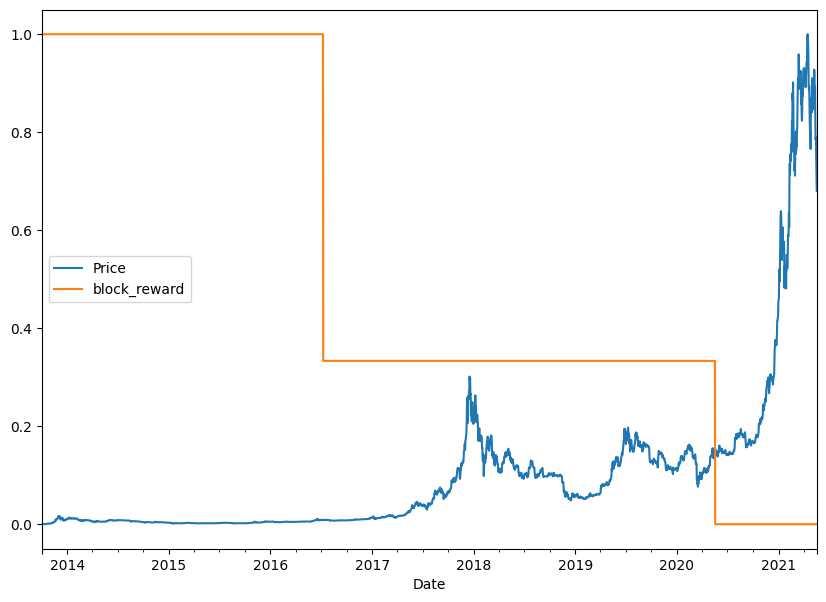

In [ ]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns, index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

### Preparing our multivariate time series for a model: Making a windowed dataset with pandas

Previously, we've turned our univariate time series into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data.

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html

In [ ]:
# Setup data hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of the bitcoin historical data with block reward
# https://www.dataquest.io/blog/settingwithcopywarning/ - Pandas copy warning
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [ ]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [ ]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [ ]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Building, fitting and evaluating a multivariate time series model

In [ ]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 1275.0078 

18/18 [==============================] - 2s 45ms/step - loss: 1275.0078 - val_loss: 1344.1726
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 225.8096

18/18 [==============================] - 1s 37ms/step - loss: 263.9096 - val_loss: 944.7201
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 186.9694 - val_loss: 1239.8353
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 216.7352

18/18 [==============================] - 1s 36ms/step - loss: 159.8582 - val_loss: 830.1775
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 133.4648

18/18 [==============================] - 1s 36ms/step - loss: 136.9606 - val_loss: 727.3138
Epoch 6/100
17/18 [===========================>..] - ETA: 0s - loss: 126.3531

18/18 [==============================] - 1s 38ms/step - loss: 128.1281 - val_loss: 677.1702
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 123.5762 - val_loss: 813.5996
Epoch 8/100
17/18 [===========================>..] - ETA: 0s - loss: 123.8260

18/18 [==============================] - 1s 37ms/step - loss: 123.8483 - val_loss: 626.8618
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 115.4741 - val_loss: 697.9039
Epoch 10/100
18/18 [==============================] - 0s 4ms/step - loss: 127.4691 - val_loss: 728.9239
Epoch 11/100
18/18 [==============================] - 0s 5ms/step - loss: 122.4070 - val_loss: 723.5365
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 122.6116 - val_loss: 663.1201
Epoch 13/100
18/18 [==============================] - 0s 6ms/step - loss: 121.1283 - val_loss: 740.3293
Epoch 14/100
18/18 [==============================] - 0s 4ms/step - loss: 118.4041 - val_loss: 659.4913
Epoch 15/100
18/18 [==============================] - 0s 6ms/step - loss: 116.8825 - val_loss: 651.6431
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 106.0963

18/18 [==============================] - 1s 60ms/step - loss: 113.3410 - val_loss: 591.5444
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 110.0386 - val_loss: 628.4104
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 121.4621

18/18 [==============================] - 1s 38ms/step - loss: 108.5850 - val_loss: 573.7614
Epoch 19/100
18/18 [==============================] - ETA: 0s - loss: 111.1073

18/18 [==============================] - 1s 37ms/step - loss: 111.1073 - val_loss: 573.4885
Epoch 20/100
18/18 [==============================] - 0s 5ms/step - loss: 106.6688 - val_loss: 583.6975
Epoch 21/100
18/18 [==============================] - 0s 5ms/step - loss: 112.0024 - val_loss: 735.7390
Epoch 22/100
18/18 [==============================] - 0s 5ms/step - loss: 118.2421 - val_loss: 576.1655
Epoch 23/100
18/18 [==============================] - 0s 5ms/step - loss: 106.9819 - val_loss: 575.0501
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 109.4320

18/18 [==============================] - 1s 35ms/step - loss: 107.5621 - val_loss: 572.5707
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 113.6578

18/18 [==============================] - 1s 51ms/step - loss: 105.1635 - val_loss: 572.1668
Epoch 26/100
18/18 [==============================] - 0s 7ms/step - loss: 106.6687 - val_loss: 596.3901
Epoch 27/100
15/18 [========================>.....] - ETA: 0s - loss: 106.4728

18/18 [==============================] - 1s 53ms/step - loss: 105.2942 - val_loss: 571.3188
Epoch 28/100
18/18 [==============================] - 0s 7ms/step - loss: 106.4608 - val_loss: 592.1133
Epoch 29/100
14/18 [======================>.......] - ETA: 0s - loss: 104.5105

18/18 [==============================] - 1s 42ms/step - loss: 105.9578 - val_loss: 571.2336
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 116.1790 - val_loss: 640.4604
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 115.3574

18/18 [==============================] - 1s 36ms/step - loss: 107.4949 - val_loss: 569.7364
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 104.9874 - val_loss: 608.0344
Epoch 33/100
18/18 [==============================] - 0s 6ms/step - loss: 106.2568 - val_loss: 574.7773
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 106.6310 - val_loss: 686.4055
Epoch 35/100
18/18 [==============================] - 0s 4ms/step - loss: 111.4604 - val_loss: 579.6871
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 106.0432 - val_loss: 591.6990
Epoch 37/100
18/18 [==============================] - 0s 5ms/step - loss: 112.8432 - val_loss: 572.8547
Epoch 38/100
18/18 [==============================] - 0s 6ms/step - loss: 107.9710 - val_loss: 570.3121
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 106.1386 - val_loss: 572.5862
Epoch 40/100
18/18 [==============================] - 0s 5ms/step - loss: 10

18/18 [==============================] - 1s 37ms/step - loss: 105.5672 - val_loss: 568.8665
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 105.5182 - val_loss: 573.8161
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 107.9163 - val_loss: 588.2698
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 104.0619 - val_loss: 608.5884
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 108.3925 - val_loss: 586.2531
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 104.9954 - val_loss: 575.0996
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 104.5125 - val_loss: 698.3895
Epoch 68/100
 1/18 [>.............................] - ETA: 0s - loss: 77.2035

18/18 [==============================] - 1s 35ms/step - loss: 105.2831 - val_loss: 567.4594
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 105.8417 - val_loss: 659.1910
Epoch 70/100
18/18 [==============================] - 0s 6ms/step - loss: 122.4089 - val_loss: 753.6962
Epoch 71/100
18/18 [==============================] - 0s 4ms/step - loss: 109.2381 - val_loss: 571.6004
Epoch 72/100
18/18 [==============================] - 0s 6ms/step - loss: 108.1711 - val_loss: 600.2539
Epoch 73/100
18/18 [==============================] - 0s 4ms/step - loss: 107.4777 - val_loss: 672.8599
Epoch 74/100
18/18 [==============================] - 0s 4ms/step - loss: 107.7807 - val_loss: 575.3030
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 104.8590 - val_loss: 570.1095
Epoch 76/100
18/18 [==============================] - 0s 4ms/step - loss: 109.1448 - val_loss: 571.7918
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 10

In [ ]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 571.4250


571.4249877929688

In [ ]:
# Load in and evaluate best performing model
model_6 = tf.keras.models.load_model("/content/model_experiments/model_6_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 567.4595


567.45947265625

In [ ]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8797.513, 8780.071, 9066.872, 8754.149, 8737.491, 8720.572,
       8656.287, 8523.686, 8427.055, 8535.935], dtype=float32)>

In [ ]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 567.4594,
 'mse': 1156106.5,
 'rmse': 1075.2239,
 'mape': 2.553796,
 'mase': 0.996869}

In [ ]:
model_1_results

{'mae': 562.942,
 'mse': 1148992.8,
 'rmse': 1071.9108,
 'mape': 2.5111601,
 'mase': 0.9889332}

For a challenge on different ways to potentially improve the multivariate time series model, see the reference here: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#model-6-dense-multivariate-time-series

## Model 7: Discussing what we're going to be doing with the N-BEATS algorithm

Let's now try to build the biggest, baddest (though maybe not the baddest, as in, it performs really well...) time series forecasting model so far.

More specifically, we're going to be replicating the algorithm in Figure 1 from the following paper:
https://arxiv.org/abs/1905.10437

Why?
* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow layer subclassing (to make our own custom layers)
* Get experience using the Functional API to create a custom architecture.
* Potentially get state-of-the-art results on our problem

### Replicating the N-BEATS basic block with TensorFlow layer subclassing

Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.

To create custom layers and models in TensorFlow we can use subclassing: https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing

In [ ]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable, name)
    # super is standard for implementing Python classes
    super().__init__(**kwargs)
    # create input variables
    # input size is window
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    # how many hidden units are within a single layer
    self.n_neurons = n_neurons
    # how many layers in the stack
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  # turn inputs into outputs
  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

### Model 7: Testing our N-BEATS block implementation with dummy data inputs

Let's test our NBeatsBlock class.

To do, we'll make some dummy inputs and outputs.

In [ ]:
# Setup dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect dense layer input requirements
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.48964545  0.19041562  0.39629832  0.47008243  0.31898612 -0.11358702
 -0.26117837]
Forecast: 0.17616328597068787


### Model 7: Creating a performant data pipeline for the N-BEATS model with tf.data

To make our input data load as fast as possible, we're going to be adhering to the performant data pipeline steps in the tf.data guide:

https://www.tensorflow.org/guide/data_performance

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create N-BEATS data inputs (N-BEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together into tuple -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024 # N-BEATS paper Table 18
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Model 7: Setting up hyperparameters for the N-BEATS algorithm

The N-BEATS algorithm has a fair few number of parameters, many of them can be found in Table 18: https://arxiv.org/pdf/1905.10437.pdf

In [ ]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512 # width parameter, number of hidden units
N_LAYERS = 30 # number of layers in fully connected stack
N_STACKS = 30 # blocks form stacks, stacks form model

INPUT_SIZE = WINDOW_SIZE * HORIZON # window size is called lookback period
THETA_SIZE = INPUT_SIZE + HORIZON # backcast + Forecast

INPUT_SIZE, THETA_SIZE

(7, 8)

### Model 7: Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecutre (section 3.2 of N-BEATS paper).

For more on residual connections see: https://en.wikipedia.org/wiki/Residual_neural_network

https://arxiv.org/abs/1512.03385

And here: https://paperswithcode.com/method/resnet

In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Model 7: Outlining the steps we're going to take to build the N-BEATS model (building, compiling, fitting)

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use `for` loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting as per section 5.2 of the N-BEATS paper
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * Early Stopping - because the model will be training for so long, we'll sotp it early if it stops improving
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning rate to reduce the amount it updates its weights each time (take smaller steps towards best performance)

### Model 7: Putting together the pieces of the puzzle of the N-BEATS model

In [ ]:
%%time
tf.random.set_seed(42)

# 1. Setup and instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create an input layer to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in (3)
  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # Pass in the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

# 8. Compile model with MAE loss
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)])


Epoch 291: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 391: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 13min 34s, sys: 1min 3s, total: 14min 38s
Wall time: 16min 54s


In [ ]:
# Evaluate N-Beats model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 96ms/step - loss: 1371.2939


1371.2939453125

In [ ]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 8s 8s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9211.42  , 9115.879 , 9114.092 , 9081.121 , 9009.118 , 8904.4795,
       8842.236 , 8801.323 , 8759.707 , 8684.418 ], dtype=float32)>

In [ ]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 1371.294,
 'mse': 7250444.5,
 'rmse': 2692.6648,
 'mape': 5.2957478,
 'mase': 2.4089837}

In [ ]:
model_1_results

{'mae': 562.942,
 'mse': 1148992.8,
 'rmse': 1071.9108,
 'mape': 2.5111601,
 'mase': 0.9889332}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

Woah... even with all of those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.

This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.

### Model 7: Plotting the N-BEATS algorithm we've created and admiring its beauty

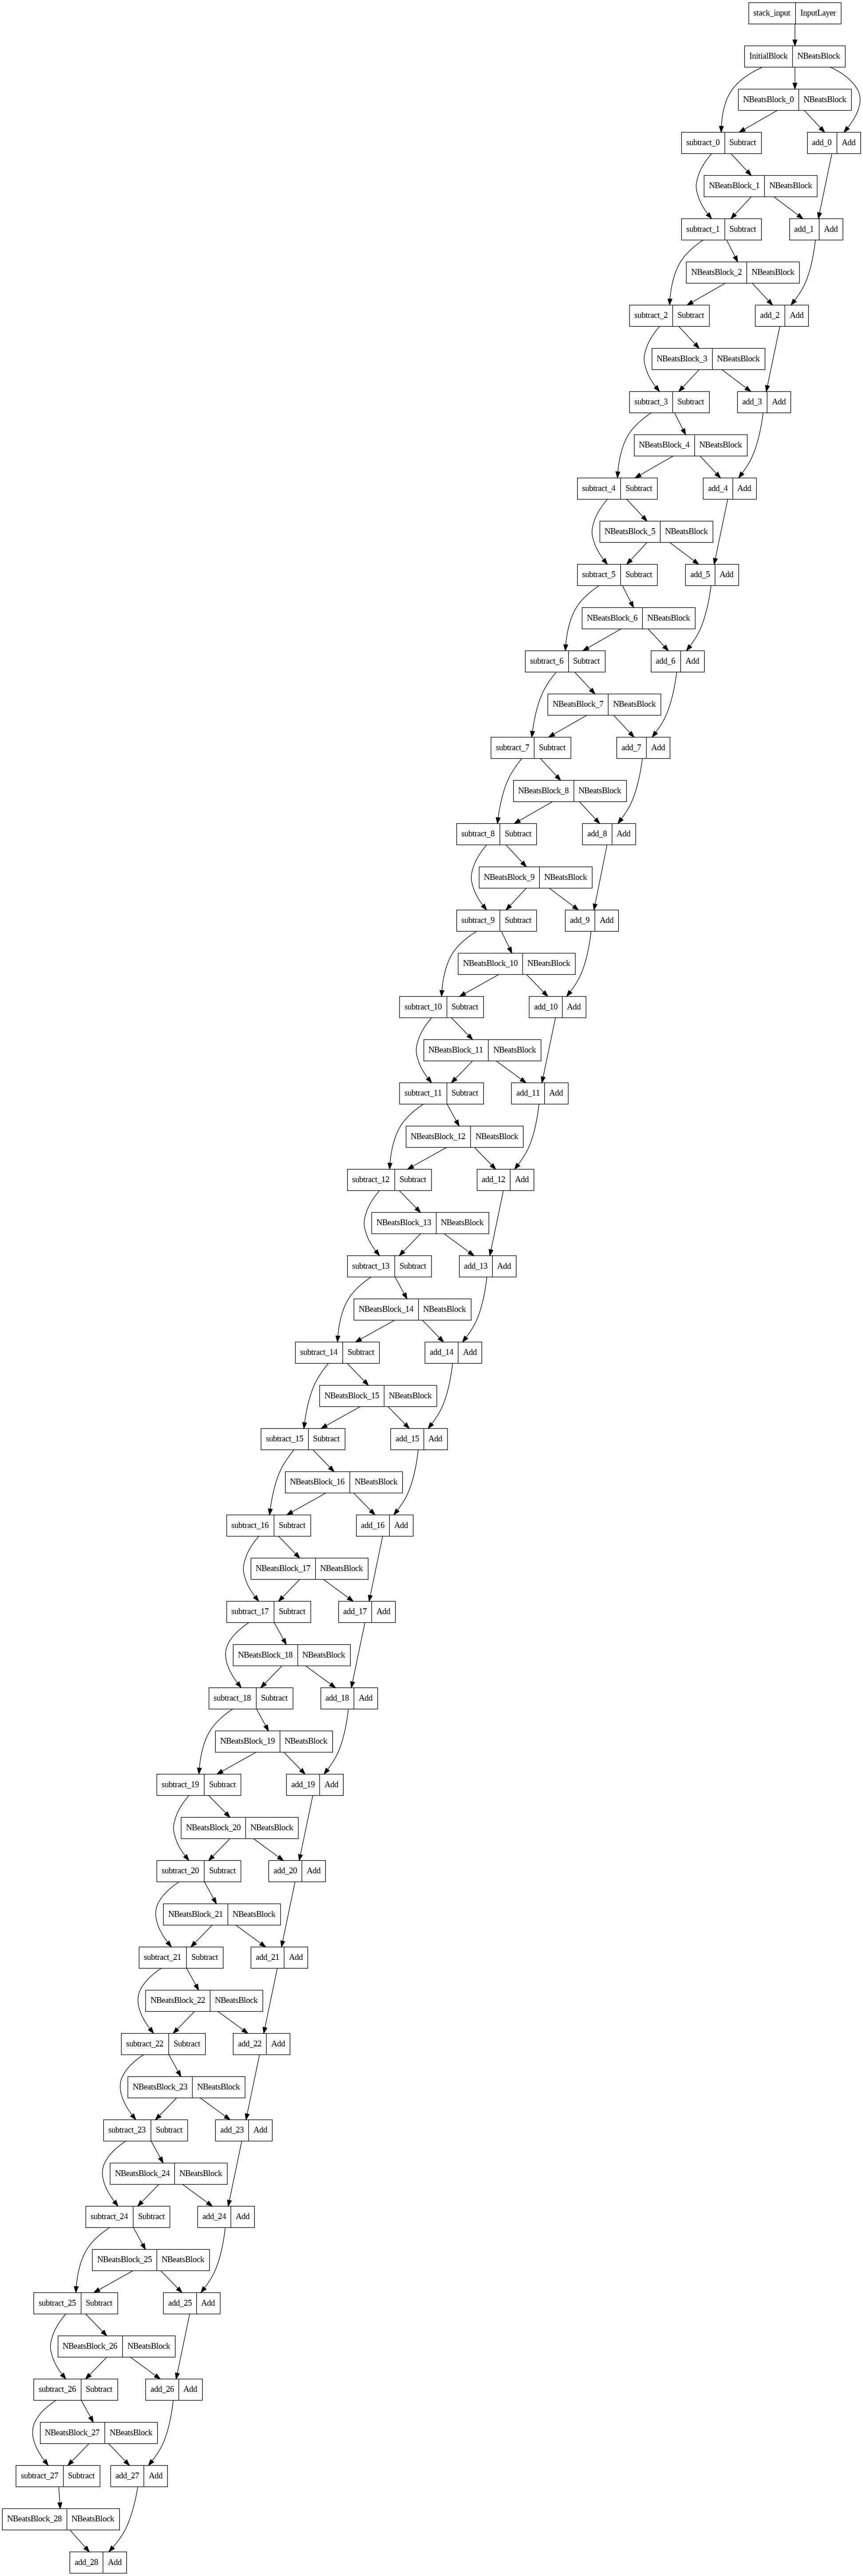

In [ ]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Ensemble model overview

### Model 8: Building, compiling and fitting an ensemble of models

An ensemble leverages the wisdom of the crowd effect.

It combines many *different* models to predict a common goal.

In [ ]:
HORIZON, WINDOW_SIZE

(1, 7)

#### Constructing and fitting an ensemble of models (using different loss functions)

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, # number of models to train
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE, and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          # Initialize dense layers with normal distribution for estimating prediction intervals later on
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit the current model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                paience=100,
                                                                verbose=1)])

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [ ]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 91: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 466: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 476: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 486: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 496: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 506: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 516: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.

Epoch 526: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.

Epoch 536: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.

Epoch 546: ReduceLROnPlateau reducing learning rate to 1.0000001044244145e-13.

Epoch 556: ReduceLROnPlateau reducing learning rate to 1.0000001179769417e-14.

Epoch 566: ReduceLROnPlateau reducing learning rate to 1.0

In [ ]:
len(ensemble_models)

15

In [ ]:
ensemble_models

### Model 8: Making and evaluating predictions with our ensemble model

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 43ms/step
CPU times: user 703 ms, sys: 29.9 ms, total: 733 ms
Wall time: 826 ms


In [ ]:
ensemble_preds

<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8870.768 ,  8803.172 ,  9109.206 , ..., 49883.984 , 48940.195 ,
        46460.32  ],
       [ 8816.598 ,  8709.216 ,  9076.721 , ..., 50190.027 , 49045.566 ,
        46061.12  ],
       [ 8816.177 ,  8762.634 ,  9061.869 , ..., 49770.996 , 47930.27  ,
        45831.97  ],
       ...,
       [ 8840.472 ,  8812.09  ,  8979.711 , ..., 50365.098 , 48057.926 ,
        46618.664 ],
       [ 8757.809 ,  8755.007 ,  9083.502 , ..., 49934.87  , 48096.332 ,
        44840.957 ],
       [ 8886.547 ,  8720.325 ,  9025.3955, ..., 49700.18  , 48571.49  ,
        45554.03  ]], dtype=float32)>

In [ ]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8818.491, 8768.302, 9037.673, 8713.425, 8745.565, 8760.575,
       8647.41 , 8482.514, 8472.206, 8510.05 ], dtype=float32)>

In [ ]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

array([8822.034, 8765.77 , 9045.491, 8709.118, 8732.404, 8776.156,
       8651.472, 8485.238, 8475.161, 8510.773], dtype=float32)

Our ensemble preds come out in multiple dimensions but to combine into **point predictions** we can leverage the mean of all the predictions or the median - https://machinelearningmastery.com/combine-predictions-for-ensemble-learning/

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean)
ensemble_results

{'mae': 568.3465,
 'mse': 1154710.0,
 'rmse': 1074.5743,
 'mape': 2.5694256,
 'mase': 0.9984274}

In [ ]:
 # Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)
ensemble_results

{'mae': 566.6704,
 'mse': 1161916.0,
 'rmse': 1077.9221,
 'mape': 2.5524364,
 'mase': 0.995483}

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_preds)
ensemble_results

{'mae': 586.09753,
 'mse': 1205492.5,
 'rmse': 1097.8419,
 'mape': 2.6547663,
 'mase': 1.029611}

## Discussing the importance of prediction intervals (uncertainty estimates) in forecasting

So far we've been making point predictions with our models.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000 USD

Wouldn't it be helpful if we knew a range of where that prediction came from?

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootsrap method:
1. Take the predictions from a number of randomly initalized models (we've got this thanks to our ensemble models)
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)
* https://en.wikipedia.org/wiki/97.5th_percentile_point
* https://www.uber.com/en-CA/blog/neural-networks-uncertainty-estimation/

### Getting the upper and lower bounds of our prediction intervals

In [ ]:
# Find the upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions from a number of randomly initialized models

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [ ]:
# Get the upper and lower bounds of the 95% percent prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)

> **Resource:** Many of the steps we've taken above have inspired/referenced from the Machine Learning Mastery blog post on [Prediction Intervals for Deep Learning Neural Networks](https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/)

### Plotting the prediction intervals of our ensemble model predictions

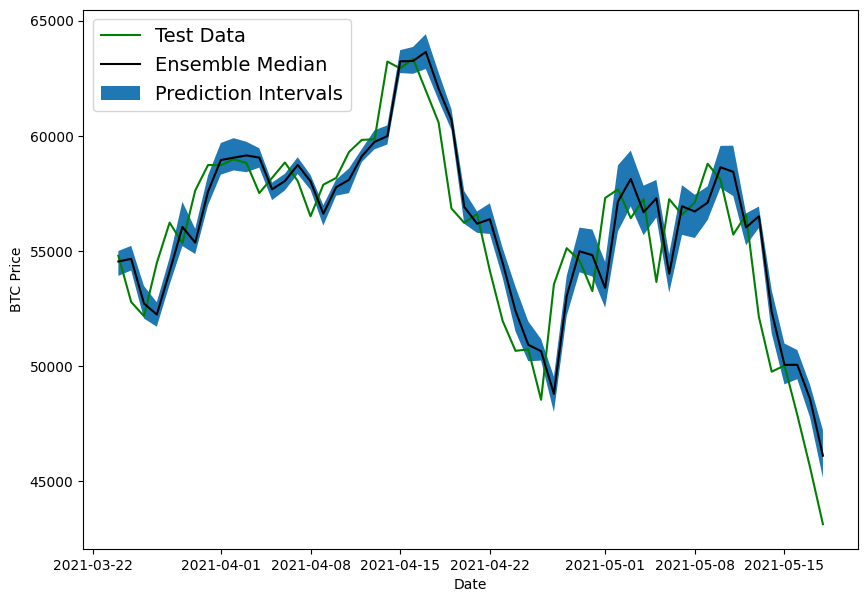

In [ ]:
# Get the median/mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset = 500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:],
                 label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

Hmm...

So far all of our models predictions have been lagging behind the test data...

As is they're replicating what the naive model does and just predict the previous timestep as the next timestep.

> **Note:** These prediction intervals are estimates themselves. And they have been created with the assumption that our model's data is from a normal distribution.

### (Optional) Discussing the types of uncertainty in machine learning

Two types of uncertainty (coconut and subway)

Uncertainty estimates in machine learning seek out to qualitatively and quantitatively answer the questions:
1. What can my model know? (with perfect data, what's possible for a model to learn?)
2. What doesn't my model know? (What can a model never predict? Or would it be helpful if a model could tell you that when it's making a prediction, it doesn't actually know if it's right or not?)

There are two major types of uncertainty in machine leanring you should know about:
* **Aleatoric uncertainty** - this type of uncertainty cannot be reduced and it is often referred to as "data" uncertainty or "subway" uncertainty
* **Epistemic uncertainty** - this type of uncertainty can be reduced, it is also referred to as "model" or "coconut" uncertainty
* https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#uncertainty-in-dating

## Model 9: Preparing data to create a model capable of predicting into the future

So far all of our models have predicted on the test dataset, however, this is only pseudofuture.

Let's now build a model which is capable of predicting into the future!

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


In [ ]:
from types import BuiltinFunctionType
# Train model on entire data to make predictions for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all), len(y_all)

(2780, 2780)

In [ ]:
X_all[:5], y_all[:5]

(array([[121.795  , 120.65533, 121.33866, 118.67466, 108.58483, 125.455  ,
         123.65499],
        [123.033  , 121.795  , 120.65533, 121.33866, 118.67466, 108.58483,
         125.455  ],
        [124.049  , 123.033  , 121.795  , 120.65533, 121.33866, 118.67466,
         108.58483],
        [125.96116, 124.049  , 123.033  , 121.795  , 120.65533, 121.33866,
         118.67466],
        [125.27966, 125.96116, 124.049  , 123.033  , 121.795  , 120.65533,
         121.33866]]),
 array([123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ]))

In [ ]:
# Turn data into efficient running tensors
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

### Model 9: Building, compiling and fitting a future predictions model

In [ ]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_9_future_model")

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0)

https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387

### Model 9: Discussing what's required for our model to make future predictions

In [ ]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # predicting 1 day at a time, predict 14 days into future

In [ ]:
tf.expand_dims(y_all[-WINDOW_SIZE:], axis=0)

<tf.Tensor: shape=(1, 7), dtype=float64, numpy=
array([[56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361, 43144.47129086]])>

To make predictions into the future we want a function which:

1. Takes as input:
  * a list of values (Bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE`) variable
  * the window size a model was trained (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the function, when it's full of predictions) and extracts the last `WINDOW_SIZE` values from the input values
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest prediction.

In [ ]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after values ends.
  Returns future forecasts as a list of floats.
  """
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(INTO_FUTURE):
    # Predict on the last window then append it again, again, again
    # (our model will eventually start to make forecasts on its own forecast)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

> **Exercise:** In terms of a forecasting model, what might another approach to our `make_future_forecasts()` function? Recall, that for making forecasts, you need to retrain a model each time you want to generate a new prediction.
>
> So perhaps you could try to: make a prediction (one timestep into the future), retrain a model with this new prediction appended to the data, make a prediction, append the prediction, retrain a model... etc.
>
> As it is, the `make_future_forecasts()` function skips the retraining of a model part.

In [ ]:
# Make forecasts into the future
future_forecast = make_future_forecasts(values=y_all,
                                        model=model_9,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 43ms/step
Predicting on
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 56277.984375

1/1 [==============================] - 0s 35ms/step
Predicting on
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 56277.984375  ] -> Prediction: 52409.82421875

1/1 [==============================] - 0s 41ms/step
Predicting on
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 56277.984375   52409.82421875] -> Prediction: 48610.94140625

1/1 [==============================] - 0s 35ms/step
Predicting on
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 56277.984375   52409.82421875 48610.94140625] -> Prediction: 49417.9765625

1/1 [==============================] - 0s 33ms/step
Predicting on
 [47885.62525472 45604.61575361 43144.47129086 56277.984375
 52409.82421875 48610.94140625 49417.9765625 ] -> Pre

In [ ]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


In [ ]:
len(future_forecast)

14

### Model 9: Plotting our model's future forecasts

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values ranging from start_date to start_date+into_future
  """

  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # returns a date range between start and end date

In [ ]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep, type(last_timestep)

(Timestamp('2021-05-18 00:00:00'), pandas._libs.tslibs.timestamps.Timestamp)

In [ ]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [ ]:
bitcoin_prices.index

DatetimeIndex(['2013-10-01', '2013-10-02', '2013-10-03', '2013-10-04',
               '2013-10-05', '2013-10-06', '2013-10-07', '2013-10-08',
               '2013-10-09', '2013-10-10',
               ...
               '2021-05-09', '2021-05-10', '2021-05-11', '2021-05-12',
               '2021-05-13', '2021-05-14', '2021-05-15', '2021-05-16',
               '2021-05-17', '2021-05-18'],
              dtype='datetime64[ns]', name='Date', length=2787, freq=None)

In [ ]:
# Insert last timestep/final price into next timesteps and future forecast so the plot doesn't look janky
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 56277.984, 52409.824, 48610.94 , 49417.977, 47560.402,
        47048.363, 46430.367, 55678.105, 51952.656, 47714.37 , 49127.63 ,
        48030.34 , 48424.793, 48764.68 ], dtype=float32))

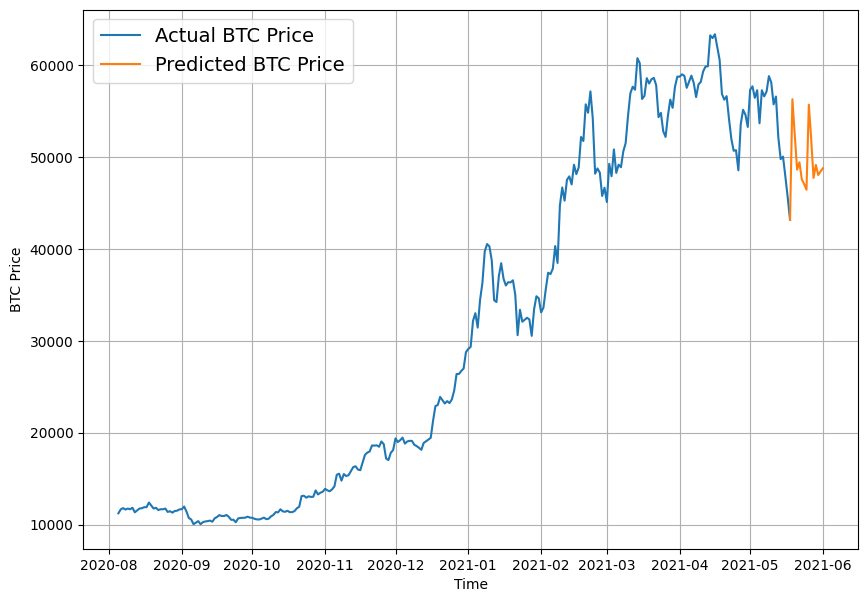

In [ ]:
# Plot future prices predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Model 10: Introducing the turkey problem and making data for it

In [ ]:
# Let's introduce a turkey problem to our BTC data (price of BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1]/100

In [ ]:
# Manufacture an extra piece on the end (to showcase our Turkey problem)
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [ ]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

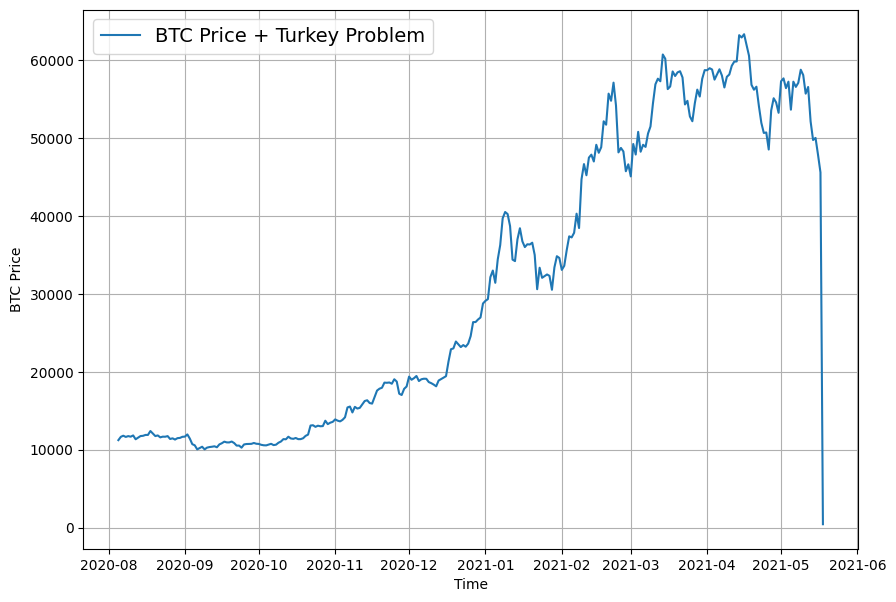

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey Problem",
                 start=2500)

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


### Model 10: Building a model to predict on turkey data (why forecasting is BS)

In [ ]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "model_10_turkey_model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 batch_size=128,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

In [ ]:
# Evaluate model on test data
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 813.5225


813.5224609375

In [ ]:
# Load best performing turkey model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/model_10_turkey_model")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 647.5768


647.5768432617188

In [ ]:
# Make predictions with turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

18/18 [==============================] - 0s 5ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8824.207, 8774.226, 9063.167, 8733.372, 8722.589, 8785.464,
       8642.383, 8521.956, 8458.097, 8533.905], dtype=float32)>

In [ ]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 17141.043,
 'mse': 615285100.0,
 'rmse': 23737.562,
 'mape': 121.52522,
 'mase': 26.52582}

In [ ]:
model_1_results

{'mae': 562.942,
 'mse': 1148992.8,
 'rmse': 1071.9108,
 'mape': 2.5111601,
 'mase': 0.9889332}

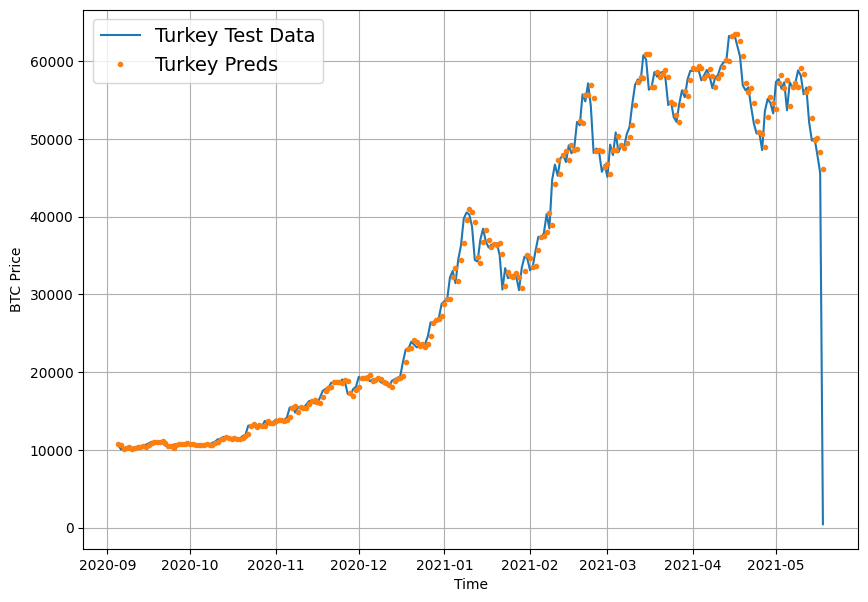

In [ ]:
plt.figure(figsize=(10, 7))
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds", start=offset);

## Comparing the results of all of our models and discussing where to go next

In [ ]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_dense_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_7_NBEATS": model_7_results,
                              "model_8_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results

,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,562.942017,1.148993e+06,1071.910767,2.511160,0.988933
model_2_dense_w30_h1,608.179565,1.304495e+06,1142.145020,2.737816,1.063104
model_3_dense_w30_h7,1237.822021,5.418676e+06,1426.379028,5.574528,2.202635
model_4_dense_CONV1D,573.562439,1.199248e+06,1095.101929,2.576868,1.007590
model_5_LSTM,584.184875,1.226594e+06,1107.517212,2.637370,1.026251
model_6_multivariate,567.459412,1.156106e+06,1075.223877,2.553796,0.996869
model_7_NBEATS,1371.293945,7.250444e+06,2692.664795,5.295748,2.408984
model_8_ensemble,586.097534,1.205492e+06,1097.841919,2.654766,1.029611
model_10_turkey,17141.042969,6.152851e+08,23737.562500,121.525223,26.525820


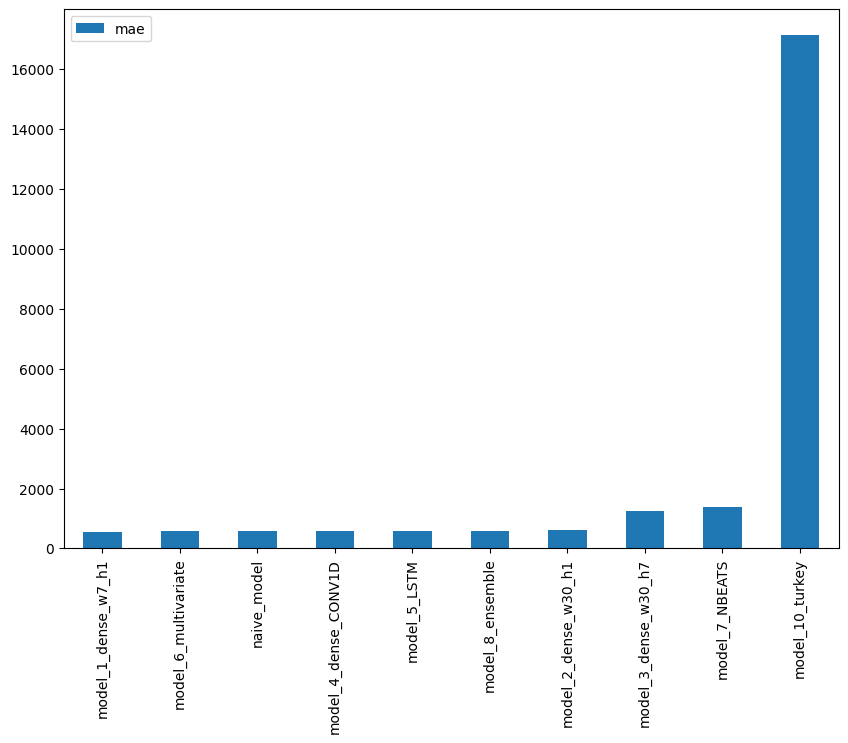

In [ ]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");